In [231]:
"""
For 2 DIMMs results
"""
import pandas as pd
import numpy as np

def get_dual_results(path):
    buffer_dist = []
    statistic = []
    buffers = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            elif (line.startswith("[Number of Buffers]")):
                buffers.append(line.strip("[Number of Buffers]").strip("\n").split(","))
            else:
                buffer_dist.append(line.strip("\n").split(","))
#     if (buffer_dist):
#         buffer_dist = np.array(buffer_dist)
#         buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1', 'total'], dtype=np.float)

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    if (buffers):
        buffers = np.array(buffers)
        buffers = pd.DataFrame(buffers, columns=['CCEH0_buffers', 'CCEH1_buffers'], dtype=np.float)
    
    print(statistic)
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    time_epoch = 0.5
    threads = 18
    max_size0 = 0
    max_size1 = 0
    for i in range(threads):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size0):
            max_size0 = th[0]

    for i in range(threads,threads*2):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size1):
            max_size1 = th[0]

    print("CCEH0 max runtime = ",max_size0, "CCEH1 max runtime = ", max_size1)
    
    MAX_SIZE = min(max_size0, max_size1)

    cceh0 = np.zeros(max_size0)
    cceh1 = np.zeros(max_size1)
    
    for i in range(threads):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]
        padding = np.pad(eopch, (0, max_size0-cur_length), 'constant', constant_values=(0,0))
        cceh0 += padding
    cceh0_Mops = cceh0[:max_size0]/time_epoch/1024/1024
    time_x = np.array([i for i in np.arange(time_epoch, (max_size0 + 1)*time_epoch, time_epoch)])
    through_x = cceh0_Mops

    for i in range(threads, threads*2):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]

        padding = np.pad(eopch, (0,max_size1-cur_length), 'constant', constant_values=(0,0))
        cceh1 += padding
        
    cceh1_Mops = cceh1[:max_size1]/time_epoch/1014/1024
    time_y = np.array([i for i in np.arange(time_epoch, (max_size1 + 1)*time_epoch, time_epoch)])
    through_y = cceh1_Mops
    
    return time_x, through_x, time_y, through_y, buffers

In [293]:
# time_d0, through_d0, time_d1, through_d1 = get_dual_results("./results_multi/cceh2_dynamic_g1.txt")
# time_d0, through_d0, time_d1, through_d1 = get_dual_results("./results_bufferdist/ccehdual2_g5.txt")
# time_f0, through_f0, time_f1, through_f1 = get_dual_results("./results_multi/cceh2_fixed_g5.txt")

time_d0, through_d0, time_d1, through_d1, dynamic_buffers1 = get_dual_results("./BufferHashing_Multi/dynamic.txt")
time_f0, through_f0, time_f1, through_f1, dynamic_buffers2 = get_dual_results("./BufferHashing_Multi/static.txt")

print (len(time_d0), len(through_d0), len(time_d1), len(through_d1))

# print(dynamic_buffers)


      thread  last_done   cur_done  seg_time     time
0       10.0        0.0   280000.0    0.5010   0.5010
1        9.0        0.0   390000.0    0.5012   0.5012
2       15.0        0.0   390000.0    0.5043   0.5043
3       17.0        0.0   300000.0    0.5051   0.5051
4        4.0        0.0   290000.0    0.5052   0.5052
...      ...        ...        ...       ...      ...
1343    22.0  7920000.0  8210000.0    0.5052  21.0103
1344    25.0  7890000.0  8180000.0    0.5037  21.0147
1345    28.0  7940000.0  8230000.0    0.5031  21.0147
1346    33.0  7900000.0  8190000.0    0.5033  21.0163
1347    29.0  7940000.0  8230000.0    0.5082  21.0169

[1348 rows x 5 columns]
CCEH0 max runtime =  35 CCEH1 max runtime =  42
      thread  last_done   cur_done  seg_time     time
0       13.0        0.0   240000.0    0.5000   0.5000
1        1.0        0.0   240000.0    0.5014   0.5014
2        2.0        0.0   240000.0    0.5015   0.5015
3       16.0        0.0   240000.0    0.5021   0.5021
4       3

/tmp/ipykernel_1011364/3240345800.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1011364/3240345800.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  buffers = pd.DataFrame(buffers, columns=['CCEH0_b

Text(0, 0.5, 'Throughput (Mops/s)')

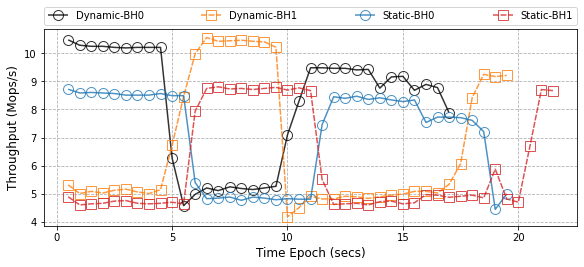

In [294]:
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', 'o', 's']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'black']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['Dynamic-BH0', 'Dynamic-BH1', 'Static-BH0', 'Static-BH1']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, ax = plt.subplots(figsize=(8, 3.6), constrained_layout=True, sharex=True, sharey=True)

ax.plot(time_d0[:-1], through_d0[:-1], color=colors[6], marker=markers[5], dashes=dashes[2], label = label[0], alpha=0.8, fillstyle='none', markersize=10)
ax.plot(time_d1[:-3], through_d1[:-3], color=colors[1], marker=markers[6], dashes=dashes[1], label = label[1], alpha=0.8, fillstyle='none', markersize=10)
ax.plot(time_f0[:-1], through_f0[:-1], color=colors[2], marker=markers[5], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=10)
ax.plot(time_f1[:-3], through_f1[:-3], color=colors[3], marker=markers[6], dashes=dashes[1], label = label[3], alpha=0.8, fillstyle='none', markersize=10)


# if (through_d0.shape[0] > through_d1.shape[0]):
#     thr1 = np.pad(through_d1, (0,through_d0.shape[0] - through_d1.shape[0]), 'constant', constant_values=(0,0))
#     ax.plot(time_d0, thr1+through_d0, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)
# else:
#     thr0 = np.pad(through_d0, (0,through_d1.shape[0] - through_d0.shape[0]), 'constant', constant_values=(0,0))
#     ax.plot(time_d1, thr0+through_d1, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)

# if (through_f0.shape[0] > through_f1.shape[0]):
#     thrb = np.pad(through_f1, (0,through_f0.shape[0] - through_f1.shape[0]), 'constant', constant_values=(0,0))
#     ax.plot(time_f0, thrb+through_f0, color=colors[5], marker=markers[5], dashes=dashes[5], label = label[5], alpha=0.8, fillstyle='none', markersize=8)
# else:
#     thra = np.pad(through_f0, (0,through_f1.shape[0] - through_f0.shape[0]), 'constant', constant_values=(0,0))
#     ax.plot(time_f1, thra+through_f1, color=colors[5], marker=markers[5], dashes=dashes[5], label = label[5], alpha=0.8, fillstyle='none', markersize=8)

ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4)

ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(True, which='both')
ax.yaxis.grid(True, which='both')

# ax[0,1].set_title('Time Epoch(1 secs) Throughput \n CCEH0 70% Write CCEH1 100% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (secs)', fontsize=12)
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)


# fig.suptitle(f'CCEH0 0% Write CCEH1 100% Write (Buffer-70K)', fontsize = 14)
# fig.supxlabel('Time Epoch (secs)', fontsize=18)
# fig.supylabel('Throughput (Mops/s)', fontsize=18)

# fig.savefig("BufferHashing_Multi/BH-Static-test1.pdf", bbox_inches='tight', pad_inches=0)

42


Text(0, 0.5, '# of Buffers (x$10^3$)')

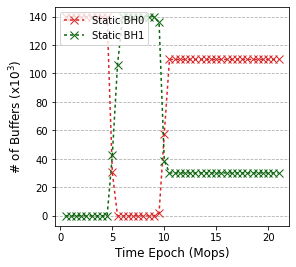

In [295]:

cceh0 = dynamic_buffers1['CCEH0_buffers'].values
cceh1 = dynamic_buffers1['CCEH1_buffers'].values
print(len(cceh0))
index = [i for i in np.arange(0.5, (len(cceh0) + 1)*0.5, 0.5)]

import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['Static BH0', 'Static BH1']

fig, ax = plt.subplots(figsize=(4, 3.6), constrained_layout=True,)

ax.plot(index, cceh0/1000, color=colors[3], marker=markers[0], dashes=dashes[0], label = label[0], fillstyle='none', markersize=8)
ax.plot(index, cceh1/1000, color=colors[4], marker=markers[0], dashes=dashes[0], label = label[1], fillstyle='none', markersize=8)

# ax.legend(loc="lower right")
ax.legend(loc="upper left")

ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax.set_title('Time Epoch(1 secs) Throughput \n CCEH0 0% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (Mops)', fontsize=12)
ax.set_ylabel('# of Buffers (x%s)' % r'$10^3$', fontsize=12)

# if (saveimg):
# fig.savefig("./BufferHashing_Multi/BH-Buffer-Dist1.pdf", bbox_inches='tight', pad_inches=0)